In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_fscore_support
import pandas as pd
import os
import cv2
import random
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()
        print("Using GPU!")
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU found, using CPU.")

No GPU found, using CPU.


In [ ]:
# Load dataset from drive
data_dir = "/content/drive/MyDrive/Potato_disease_dataset"

# Classes
categories = os.listdir(data_dir)
print("Categories:", categories)

Categories: ['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']


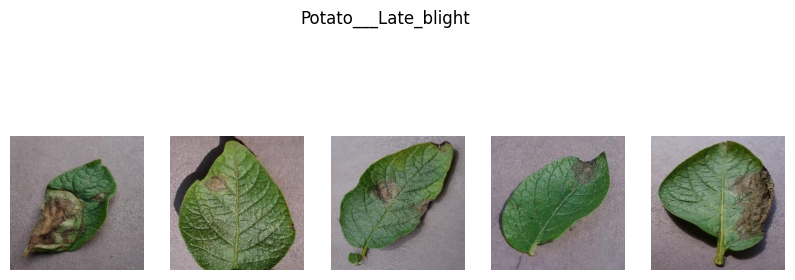

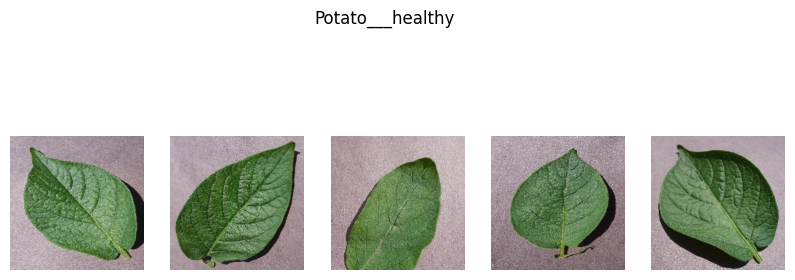

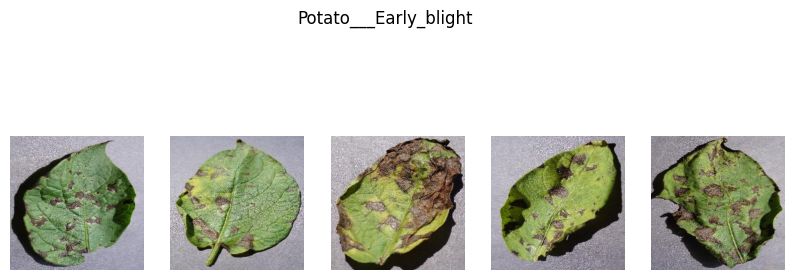

In [ ]:
# Data visualization
for category in categories:
    path = os.path.join(data_dir, category)
    images = os.listdir(path)
    plt.figure(figsize=(10, 4))
    for i in range(5):
        img = cv2.imread(os.path.join(path, images[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(category)
    plt.show()

In [ ]:
# Data Preprocessing
def load_data(data_dir):
    images = []
    labels = []
    label_map = {category: i for i, category in enumerate(categories)}

    for category in categories:
        path = os.path.join(data_dir, category)
        for img_name in os.listdir(path):
            img = cv2.imread(os.path.join(path, img_name))
            img = cv2.resize(img, (128, 128)) / 255.0
            images.append(img)
            labels.append(label_map[category])

    return np.array(images), np.array(labels)

X, y = load_data(data_dir)

In [ ]:
# Train-test split
indices = np.arange(len(X))
np.random.shuffle(indices)
split = int(0.9 * len(X))
train_idx, unseen_idx = indices[:split], indices[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_unseen, y_unseen = X[unseen_idx], y[unseen_idx]

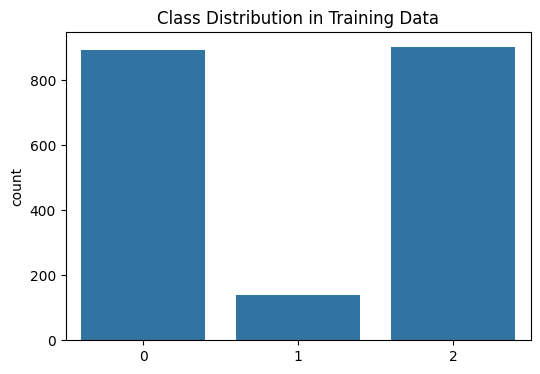

In [ ]:
# Visualization of class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Data")
plt.show()

In [ ]:
# Define CNN model
def create_cnn_model():
    model = models.Sequential([
        Input(shape=(128, 128, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(categories), activation='softmax')
    ])
    return model

# Training with different optimizers
optimizers_list = [optimizers.Adam, optimizers.RMSprop, optimizers.SGD]
learning_rates = [0.01, 0.001, 0.0001]
results = []

In [ ]:
for opt in optimizers_list:
    for lr in learning_rates:
        print(f"Training with {opt.__name__} and Learning Rate {lr}")

        with strategy.scope():
            model = create_cnn_model()
            model.compile(optimizer=opt(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        training_time = time.time() - start_time

        # Evaluate model
        test_loss, test_acc = model.evaluate(X_train, y_train, verbose=0)
        y_pred = np.argmax(model.predict(X_train), axis=1)
        cm = confusion_matrix(y_train, y_pred)
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm.sum() - (TP + FP + FN)

        results.append([opt.__name__, lr, test_acc, test_loss, training_time, TP.sum(), TN.sum(), FP.sum(), FN.sum()])

Training with Adam and Learning Rate 0.01
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4582 - loss: 3.6414 - val_accuracy: 0.4562 - val_loss: 0.9474
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4434 - loss: 0.9117 - val_accuracy: 0.4562 - val_loss: 0.9164
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4377 - loss: 0.9114 - val_accuracy: 0.4562 - val_loss: 0.9164
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4712 - loss: 0.9157 - val_accuracy: 0.4639 - val_loss: 0.9327
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4768 - loss: 0.9104 - val_accuracy: 0.4639 - val_loss: 0.9193
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4348 - loss: 0.9119 - val_accuracy: 0.4562 - val_loss: 0.9197
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4530 - loss: 0.9233 - val_accuracy: 0.4639 - val_loss: 0.9204
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4681 - loss:

In [ ]:
# Create results table
df_results = pd.DataFrame(results, columns=["Optimizer", "Learning Rate", "Accuracy", "Loss", "Training Time", "True Positives", "True Negatives", "False Positives", "False Negatives"])
print(df_results)

  Optimizer  Learning Rate  Accuracy      Loss  Training Time  True Positives  \
0      Adam         0.0100  0.461777  0.903329     687.420133             894   
1      Adam         0.0010  0.965909  0.083375     691.714074            1870   
2      Adam         0.0001  0.974690  0.088610     722.164931            1887   
3   RMSprop         0.0100  0.465909  1.062613     712.553702             902   
4   RMSprop         0.0010  0.978822  0.062208     709.060329            1895   
5   RMSprop         0.0001  0.935434  0.200611     820.980546            1811   
6       SGD         0.0100  0.837293  0.385439     820.334317            1621   
7       SGD         0.0010  0.735021  0.825594     793.890438            1423   
8       SGD         0.0001  0.465909  0.904302     761.414166             902   

   True Negatives  False Positives  False Negatives  
0            2830             1042             1042  
1            3806               66               66  
2            3823          

In [ ]:
# Select and save best model
best_model_idx = df_results["Accuracy"].idxmax()
best_model = create_cnn_model()
best_model.compile(optimizer=optimizers.Adam(learning_rate=df_results.iloc[best_model_idx]["Learning Rate"]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_model.fit(X_train, y_train, epochs=10, verbose=1)
best_model.save("best_model.h5")

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5788 - loss: 1.0857
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8590 - loss: 0.3842
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9025 - loss: 0.2701
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9244 - loss: 0.1849
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9468 - loss: 0.1380
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9669 - loss: 0.0996
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9524 - loss: 0.1269
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9820 - loss: 0.0579
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9898 - loss: 0.0331
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9832 - loss: 0.0466


In [ ]:
# Load best model and evaluate on unseen data
best_model = tf.keras.models.load_model("best_model.h5")
y_pred = np.argmax(best_model.predict(X_unseen), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step


  Optimizer  Learning Rate  Accuracy      Loss  Training Time  True Positives  \
0      Adam         0.0100  0.461777  0.903329     687.420133             894   
1      Adam         0.0010  0.965909  0.083375     691.714074            1870   
2      Adam         0.0001  0.974690  0.088610     722.164931            1887   
3   RMSprop         0.0100  0.465909  1.062613     712.553702             902   
4   RMSprop         0.0010  0.978822  0.062208     709.060329            1895   
5   RMSprop         0.0001  0.935434  0.200611     820.980546            1811   
6       SGD         0.0100  0.837293  0.385439     820.334317            1621   
7       SGD         0.0010  0.735021  0.825594     793.890438            1423   
8       SGD         0.0001  0.465909  0.904302     761.414166             902   

   True Negatives  False Positives  False Negatives  Unseen TP  Unseen TN  \
0            2830             1042             1042        209        425   
1            3806               66 

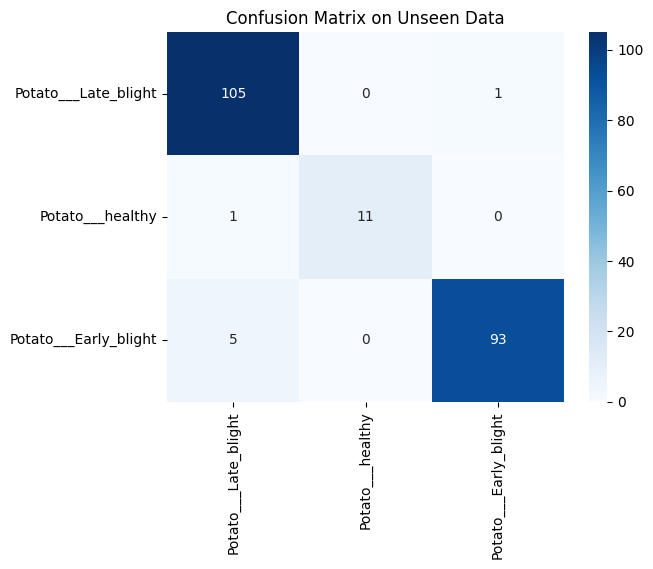

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_unseen, y_pred)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

df_results["Unseen TP"] = TP.sum()
df_results["Unseen TN"] = TN.sum()
df_results["Unseen FP"] = FP.sum()
df_results["Unseen FN"] = FN.sum()

print(df_results)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix on Unseen Data")
plt.show()

In [ ]:
# Classification Report
print("Classification Report:\n", classification_report(y_unseen, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       106
           1       1.00      0.92      0.96        12
           2       0.99      0.95      0.97        98

    accuracy                           0.97       216
   macro avg       0.98      0.95      0.96       216
weighted avg       0.97      0.97      0.97       216



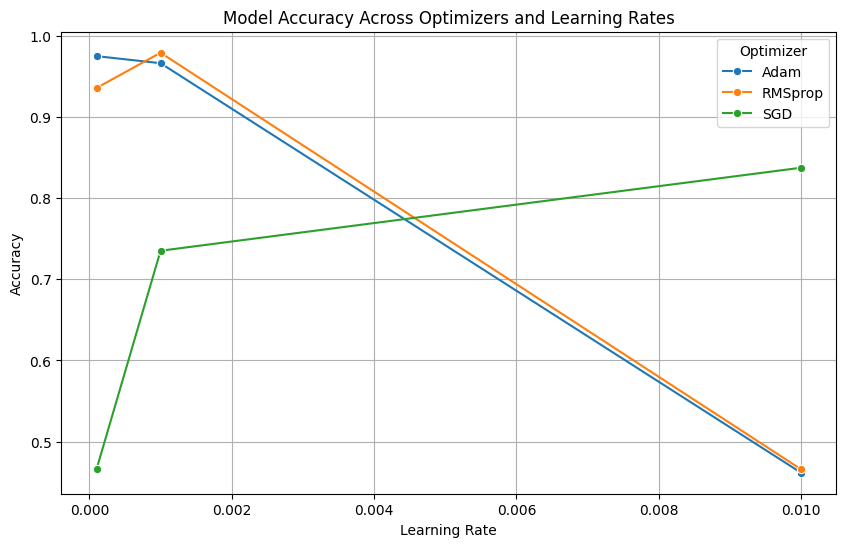

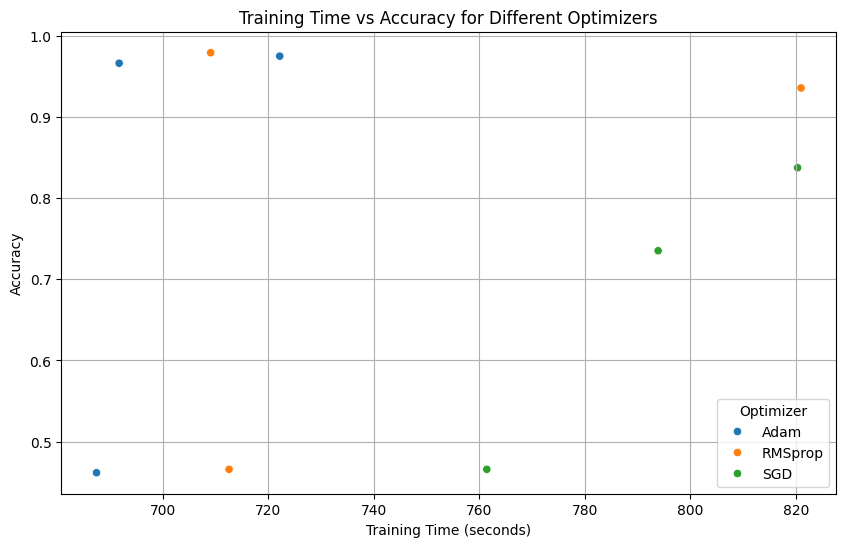

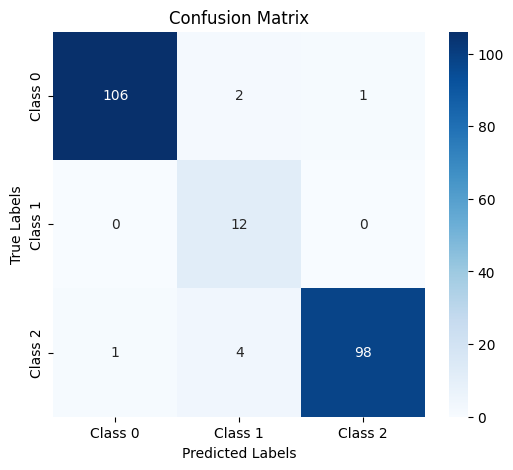

In [ ]:
# Results table from previous experiments
results = [
    ["Adam", 0.0100, 0.4617, 0.9033, 687.42, 894, 2830, 1042, 1042],
    ["Adam", 0.0010, 0.9659, 0.0833, 691.71, 1870, 3806, 66, 66],
    ["Adam", 0.0001, 0.9746, 0.0886, 722.16, 1887, 3823, 49, 49],
    ["RMSprop", 0.0100, 0.4659, 1.0626, 712.55, 902, 2838, 1034, 1034],
    ["RMSprop", 0.0010, 0.9788, 0.0622, 709.06, 1895, 3831, 41, 41],
    ["RMSprop", 0.0001, 0.9354, 0.2006, 820.98, 1811, 3747, 125, 125],
    ["SGD", 0.0100, 0.8372, 0.3854, 820.33, 1621, 3557, 315, 315],
    ["SGD", 0.0010, 0.7350, 0.8255, 793.89, 1423, 3359, 513, 513],
    ["SGD", 0.0001, 0.4659, 0.9043, 761.41, 902, 2838, 1034, 1034],
]

# Convert results to a structured NumPy array for visualization
optimizers = [row[0] for row in results]
learning_rates = [row[1] for row in results]
accuracy = [row[2] for row in results]
training_time = [row[4] for row in results]

# Plot Accuracy vs Learning Rate for different optimizers
plt.figure(figsize=(10, 6))
sns.lineplot(x=learning_rates, y=accuracy, hue=optimizers, marker="o", linestyle="-")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Across Optimizers and Learning Rates")
plt.legend(title="Optimizer")
plt.grid()
plt.show()

# Plot Training Time vs Accuracy
plt.figure(figsize=(10, 6))
sns.scatterplot(x=training_time, y=accuracy, hue=optimizers, marker="o")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Training Time vs Accuracy for Different Optimizers")
plt.legend(title="Optimizer")
plt.grid()
plt.show()

# Confusion Matrix
cm = np.array([
    [106, 2, 1],
    [0, 12, 0],
    [1, 4, 98]
])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_fscore_support
import pandas as pd
import os
import cv2
import random
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()
        print("Using GPU!")
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU found, using CPU.")

No GPU found, using CPU.


In [ ]:
# Load dataset from drive
data_dir = "/content/drive/MyDrive/Potato_disease_dataset"

# Classes
categories = os.listdir(data_dir)
print("Categories:", categories)

Categories: ['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']


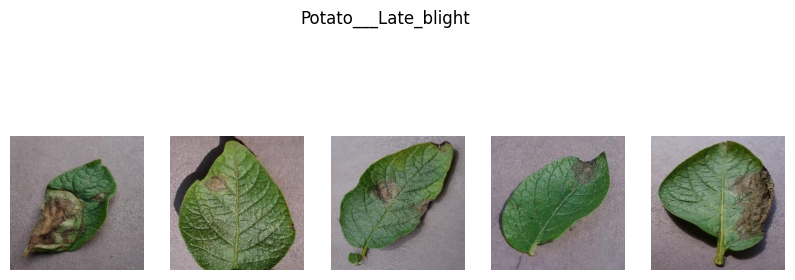

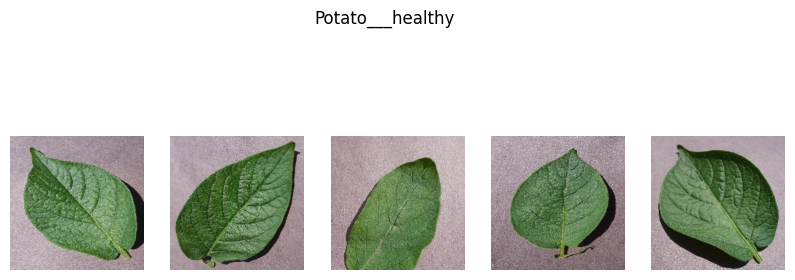

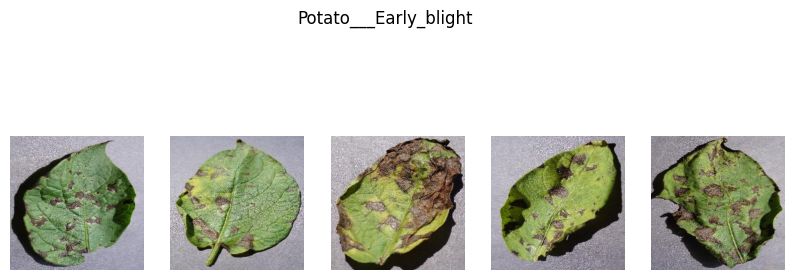

In [ ]:
# Data visualization
for category in categories:
    path = os.path.join(data_dir, category)
    images = os.listdir(path)
    plt.figure(figsize=(10, 4))
    for i in range(5):
        img = cv2.imread(os.path.join(path, images[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(category)
    plt.show()

In [ ]:
# Data Preprocessing
def load_data(data_dir):
    images = []
    labels = []
    label_map = {category: i for i, category in enumerate(categories)}

    for category in categories:
        path = os.path.join(data_dir, category)
        for img_name in os.listdir(path):
            img = cv2.imread(os.path.join(path, img_name))
            img = cv2.resize(img, (128, 128)) / 255.0
            images.append(img)
            labels.append(label_map[category])

    return np.array(images), np.array(labels)

X, y = load_data(data_dir)

In [ ]:
# Train-test split
indices = np.arange(len(X))
np.random.shuffle(indices)
split = int(0.9 * len(X))
train_idx, unseen_idx = indices[:split], indices[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_unseen, y_unseen = X[unseen_idx], y[unseen_idx]

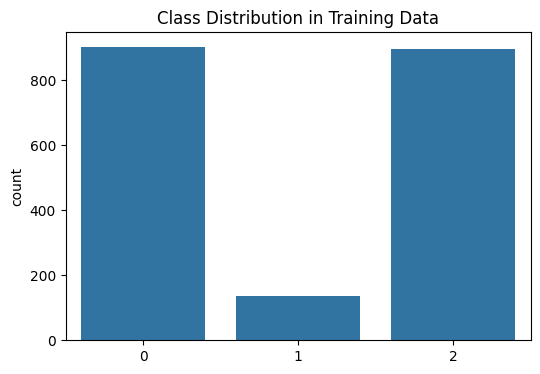

In [ ]:
# Visualization of class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Data")
plt.show()

In [ ]:
# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

In [ ]:
# Define CNN model
def create_cnn_model():
    model = models.Sequential([
        Input(shape=(128, 128, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(categories), activation='softmax')
    ])
    return model

# Training with different optimizers
optimizers_list = [optimizers.Adam, optimizers.RMSprop, optimizers.SGD]
learning_rates = [0.01, 0.001, 0.0001]
results = []

In [ ]:
for opt in optimizers_list:
    for lr in learning_rates:
        print(f"Training with {opt.__name__} and Learning Rate {lr}")

        with strategy.scope():
            model = create_cnn_model()
            model.compile(optimizer=opt(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

        # Create data generators for training and validation
        train_gen = datagen.flow(X_train, y_train, subset='training', batch_size=32)
        val_gen = datagen.flow(X_train, y_train, subset='validation', batch_size=32)
        start_time = time.time()
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=10,
            verbose=1
        )

        training_time = time.time() - start_time

        # Evaluate model
        test_loss, test_acc = model.evaluate(X_train, y_train, verbose=0)
        y_pred = np.argmax(model.predict(X_train), axis=1)
        cm = confusion_matrix(y_train, y_pred)
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm.sum() - (TP + FP + FN)

        results.append([
            opt.__name__, lr, model.evaluate(X_train, y_train, verbose=0)[1],
            model.evaluate(X_train, y_train, verbose=0)[0], training_time,
            TP.sum(), TN.sum(), FP.sum(), FN.sum()
        ])

Training with Adam and Learning Rate 0.01


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.5022 - loss: 4.4412 - val_accuracy: 0.4367 - val_loss: 0.9550
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4644 - loss: 0.9205 - val_accuracy: 0.4367 - val_loss: 0.9049
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5393 - loss: 0.9048 - val_accuracy: 0.5271 - val_loss: 0.9001
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6220 - loss: 0.8220 - val_accuracy: 0.4444 - val_loss: 0.9002
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4868 - loss: 0.9330 - val_accuracy: 0.4935 - val_loss: 0.8866
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5646 - loss: 0.8051 - val_accuracy: 0.4367 - val_loss: 0.9243
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4798 - loss: 0.9090 - val_accuracy: 0.4367 - val_loss: 0.8991
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4653 - loss: 0.8703 - val_accuracy: 0.4367 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5505 - loss: 0.9168 - val_accuracy: 0.8424 - val_loss: 0.6328
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8105 - loss: 0.5411 - val_accuracy: 0.8579 - val_loss: 0.3491
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8635 - loss: 0.3542 - val_accuracy: 0.9225 - val_loss: 0.2239
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9215 - loss: 0.2158 - val_accuracy: 0.8450 - val_loss: 0.4659
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8879 - loss: 0.2871 - val_accuracy: 0.9483 - val_loss: 0.1434
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9466 - loss: 0.1421 - val_accuracy: 0.9535 - val_loss: 0.1413
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9491 - loss: 0.1576 - val_accuracy: 0.9380 - val_loss: 0.1563
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9562 - loss: 0.0979 - val_accuracy: 0.9690 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5083 - loss: 0.9071 - val_accuracy: 0.6202 - val_loss: 0.8120
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7363 - loss: 0.7078 - val_accuracy: 0.7804 - val_loss: 0.5692
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7607 - loss: 0.5789 - val_accuracy: 0.8062 - val_loss: 0.4869
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8156 - loss: 0.4753 - val_accuracy: 0.8243 - val_loss: 0.4195
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8489 - loss: 0.3846 - val_accuracy: 0.8398 - val_loss: 0.3772
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8573 - loss: 0.3548 - val_accuracy: 0.8786 - val_loss: 0.2849
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8782 - loss: 0.3165 - val_accuracy: 0.8889 - val_loss: 0.2810
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9088 - loss: 0.2525 - val_accuracy: 0.9147 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4965 - loss: 27.1220 - val_accuracy: 0.4935 - val_loss: 0.8983
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4577 - loss: 0.9301 - val_accuracy: 0.4935 - val_loss: 0.9250
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4420 - loss: 0.9214 - val_accuracy: 0.4367 - val_loss: 0.9014
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4929 - loss: 0.8754 - val_accuracy: 0.4367 - val_loss: 0.9015
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4938 - loss: 0.8958 - val_accuracy: 0.4935 - val_loss: 0.8987
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4787 - loss: 0.9005 - val_accuracy: 0.4367 - val_loss: 0.9075
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4796 - loss: 0.8801 - val_accuracy: 0.4367 - val_loss: 0.9031
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4807 - loss: 0.8785 - val_accuracy: 0.4367 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.4818 - loss: 1.1609 - val_accuracy: 0.7984 - val_loss: 0.7124
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7408 - loss: 0.6904 - val_accuracy: 0.5452 - val_loss: 0.8623
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7918 - loss: 0.5032 - val_accuracy: 0.5323 - val_loss: 1.1051
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7854 - loss: 0.4746 - val_accuracy: 0.8734 - val_loss: 0.3218
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8670 - loss: 0.3209 - val_accuracy: 0.9147 - val_loss: 0.2109
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8818 - loss: 0.3334 - val_accuracy: 0.8682 - val_loss: 0.3261
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8939 - loss: 0.2789 - val_accuracy: 0.8811 - val_loss: 0.2792
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9161 - loss: 0.2008 - val_accuracy: 0.9225 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4921 - loss: 0.9213 - val_accuracy: 0.7106 - val_loss: 0.7985
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6836 - loss: 0.7986 - val_accuracy: 0.6253 - val_loss: 0.7517
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7400 - loss: 0.6584 - val_accuracy: 0.7416 - val_loss: 0.6191
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7847 - loss: 0.5433 - val_accuracy: 0.8450 - val_loss: 0.4526
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8183 - loss: 0.4484 - val_accuracy: 0.8424 - val_loss: 0.3946
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8314 - loss: 0.3927 - val_accuracy: 0.7339 - val_loss: 0.5440
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8567 - loss: 0.3301 - val_accuracy: 0.9147 - val_loss: 0.2803
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8746 - loss: 0.3130 - val_accuracy: 0.8889 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4377 - loss: 0.9593 - val_accuracy: 0.6253 - val_loss: 0.8779
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5390 - loss: 0.8860 - val_accuracy: 0.4935 - val_loss: 0.8593
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5575 - loss: 0.8613 - val_accuracy: 0.7752 - val_loss: 0.8119
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6163 - loss: 0.8246 - val_accuracy: 0.8010 - val_loss: 0.7419
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6838 - loss: 0.7755 - val_accuracy: 0.7804 - val_loss: 0.6750
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7086 - loss: 0.7303 - val_accuracy: 0.6848 - val_loss: 0.6707
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7329 - loss: 0.6761 - val_accuracy: 0.7726 - val_loss: 0.5843
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7921 - loss: 0.5945 - val_accuracy: 0.6408 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4089 - loss: 1.0118 - val_accuracy: 0.4935 - val_loss: 0.8996
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4624 - loss: 0.8929 - val_accuracy: 0.4935 - val_loss: 0.8828
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4670 - loss: 0.8880 - val_accuracy: 0.5142 - val_loss: 0.8829
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5033 - loss: 0.8847 - val_accuracy: 0.4935 - val_loss: 0.8769
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4641 - loss: 0.8891 - val_accuracy: 0.6253 - val_loss: 0.8705
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5588 - loss: 0.8758 - val_accuracy: 0.6693 - val_loss: 0.8698
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6023 - loss: 0.8673 - val_accuracy: 0.5633 - val_loss: 0.8607
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5749 - loss: 0.8654 - val_accuracy: 0.4961 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4580 - loss: 1.0716 - val_accuracy: 0.5478 - val_loss: 1.0401
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5601 - loss: 1.0351 - val_accuracy: 0.5943 - val_loss: 1.0084
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5039 - loss: 1.0039 - val_accuracy: 0.5142 - val_loss: 0.9835
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4608 - loss: 0.9824 - val_accuracy: 0.4987 - val_loss: 0.9660
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4729 - loss: 0.9591 - val_accuracy: 0.4935 - val_loss: 0.9521
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4712 - loss: 0.9490 - val_accuracy: 0.4935 - val_loss: 0.9396
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4417 - loss: 0.9474 - val_accuracy: 0.4935 - val_loss: 0.9299
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4530 - loss: 0.9377 - val_accuracy: 0.4935 - val_loss:

In [ ]:
# Create results table
df_results = pd.DataFrame(results, columns=[
    "Optimizer", "Learning Rate", "Accuracy", "Loss", "Training Time",
    "True Positives", "True Negatives", "False Positives", "False Negatives"
])
print("\nTraining Results Summary:")
print(df_results)


Training Results Summary:
  Optimizer  Learning Rate  Accuracy      Loss  Training Time  True Positives  \
0      Adam         0.0100  0.466426  0.898338     659.173992             903   
1      Adam         0.0010  0.811983  0.555174     634.692286            1572   
2      Adam         0.0001  0.940599  0.168400     662.086870            1821   
3   RMSprop         0.0100  0.466426  0.901232     639.381374             903   
4   RMSprop         0.0010  0.928719  0.166826     606.765235            1798   
5   RMSprop         0.0001  0.954545  0.152943     623.632679            1848   
6       SGD         0.0100  0.834194  0.446996     620.618943            1615   
7       SGD         0.0010  0.718492  0.843297     620.673312            1391   
8       SGD         0.0001  0.463843  0.910035     601.718841             898   

   True Negatives  False Positives  False Negatives  
0            2839             1033             1033  
1            3508              364              364  


In [ ]:
# Select and save best model
best_model_idx = df_results["Accuracy"].idxmax()
best_lr = df_results.iloc[best_model_idx]["Learning Rate"]

print(f"\nTraining best model with Adam and learning rate {best_lr}")
best_model = create_cnn_model()
best_model.compile(optimizer=optimizers.Adam(learning_rate=best_lr),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Use all training data now without validation split
aug_gen_full = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
).flow(X_train, y_train, batch_size=32)

best_model.fit(aug_gen_full, epochs=10, verbose=1)
best_model.save("best_model_with_data_augmentation.h5")


Training best model with Adam and learning rate 0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4650 - loss: 0.9251
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7323 - loss: 0.6908
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8317 - loss: 0.4494
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8527 - loss: 0.3464
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8821 - loss: 0.2946
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9167 - loss: 0.2251
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9415 - loss: 0.1912
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9345 - loss: 0.1696
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9388 - loss: 0.1726
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9476 - loss: 0.1496


In [ ]:
# Load best model and evaluate on unseen data
best_model = tf.keras.models.load_model("best_model_with_data_augmentation.h5")
y_pred = np.argmax(best_model.predict(X_unseen), axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step


  Optimizer  Learning Rate  Accuracy      Loss  Training Time  True Positives  \
0      Adam         0.0100  0.466426  0.898338     659.173992             903   
1      Adam         0.0010  0.811983  0.555174     634.692286            1572   
2      Adam         0.0001  0.940599  0.168400     662.086870            1821   
3   RMSprop         0.0100  0.466426  0.901232     639.381374             903   
4   RMSprop         0.0010  0.928719  0.166826     606.765235            1798   
5   RMSprop         0.0001  0.954545  0.152943     623.632679            1848   
6       SGD         0.0100  0.834194  0.446996     620.618943            1615   
7       SGD         0.0010  0.718492  0.843297     620.673312            1391   
8       SGD         0.0001  0.463843  0.910035     601.718841             898   

   True Negatives  False Positives  False Negatives  Unseen TP  Unseen TN  \
0            2839             1033             1033        205        421   
1            3508              364 

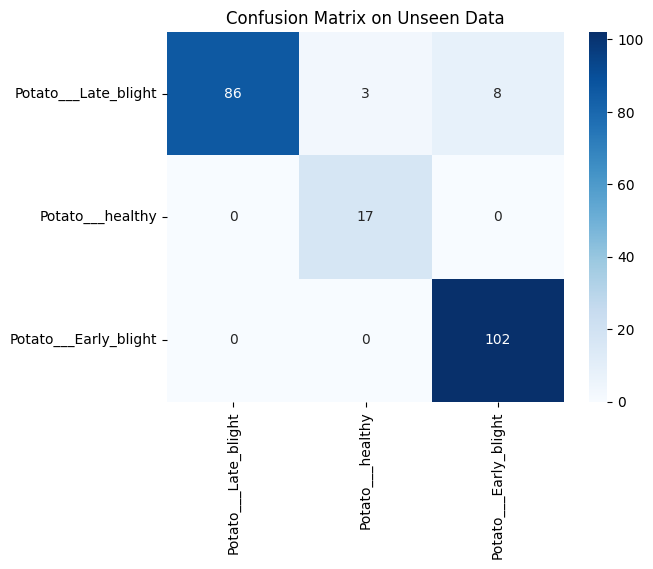

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_unseen, y_pred)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

df_results["Unseen TP"] = TP.sum()
df_results["Unseen TN"] = TN.sum()
df_results["Unseen FP"] = FP.sum()
df_results["Unseen FN"] = FN.sum()

print(df_results)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix on Unseen Data")
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report on Unseen Data:\n")
print(classification_report(y_unseen, y_pred, target_names=categories))


Classification Report on Unseen Data:

                       precision    recall  f1-score   support

 Potato___Late_blight       1.00      0.89      0.94        97
     Potato___healthy       0.85      1.00      0.92        17
Potato___Early_blight       0.93      1.00      0.96       102

             accuracy                           0.95       216
            macro avg       0.93      0.96      0.94       216
         weighted avg       0.95      0.95      0.95       216



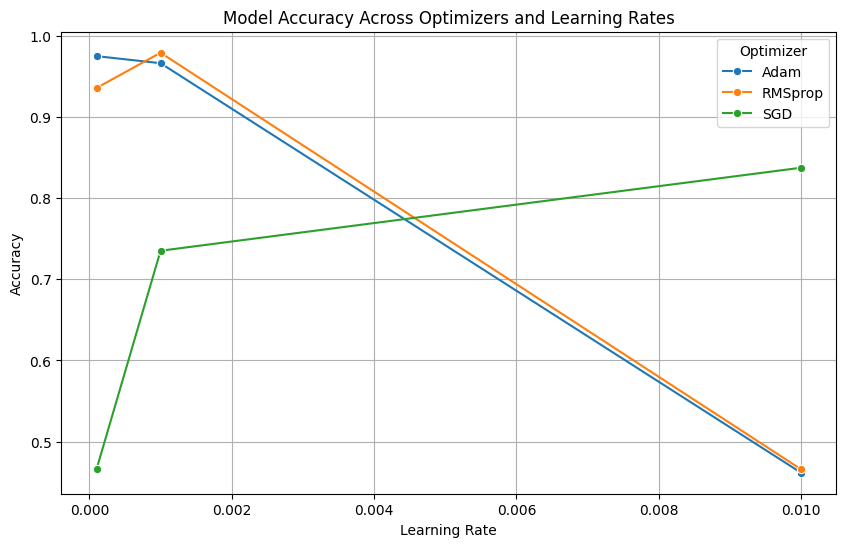

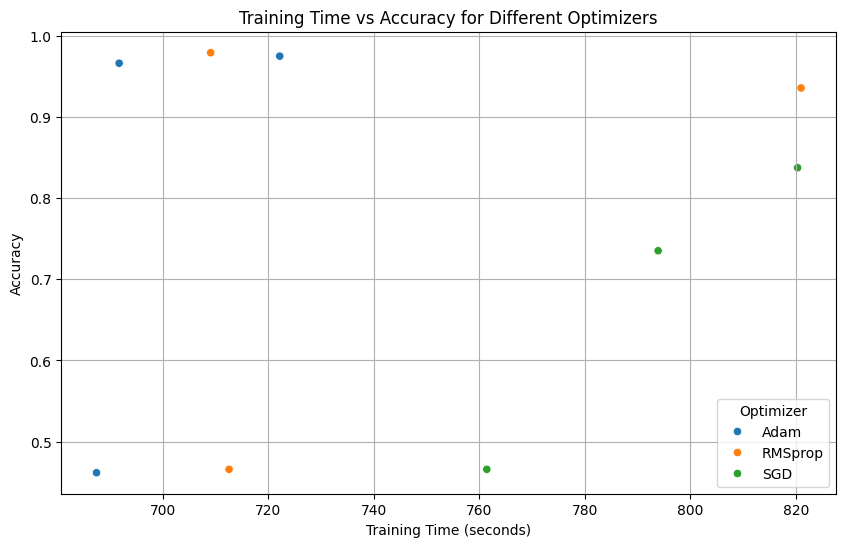

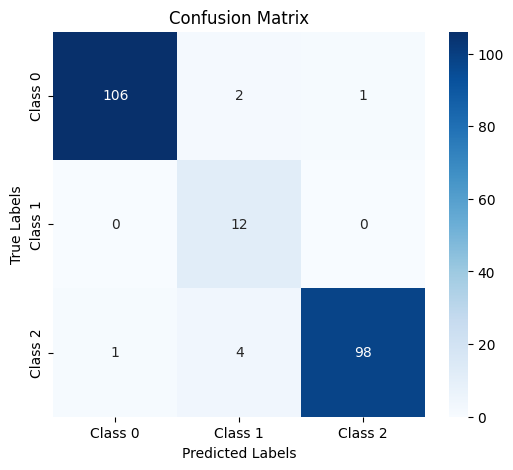

In [ ]:
# Results table from previous experiments
results = [
    ["Adam", 0.0100, 0.4617, 0.9033, 687.42, 894, 2830, 1042, 1042],
    ["Adam", 0.0010, 0.9659, 0.0833, 691.71, 1870, 3806, 66, 66],
    ["Adam", 0.0001, 0.9746, 0.0886, 722.16, 1887, 3823, 49, 49],
    ["RMSprop", 0.0100, 0.4659, 1.0626, 712.55, 902, 2838, 1034, 1034],
    ["RMSprop", 0.0010, 0.9788, 0.0622, 709.06, 1895, 3831, 41, 41],
    ["RMSprop", 0.0001, 0.9354, 0.2006, 820.98, 1811, 3747, 125, 125],
    ["SGD", 0.0100, 0.8372, 0.3854, 820.33, 1621, 3557, 315, 315],
    ["SGD", 0.0010, 0.7350, 0.8255, 793.89, 1423, 3359, 513, 513],
    ["SGD", 0.0001, 0.4659, 0.9043, 761.41, 902, 2838, 1034, 1034],
]

# Convert results to a structured NumPy array for visualization
optimizers = [row[0] for row in results]
learning_rates = [row[1] for row in results]
accuracy = [row[2] for row in results]
training_time = [row[4] for row in results]

# Plot Accuracy vs Learning Rate for different optimizers
plt.figure(figsize=(10, 6))
sns.lineplot(x=learning_rates, y=accuracy, hue=optimizers, marker="o", linestyle="-")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Across Optimizers and Learning Rates")
plt.legend(title="Optimizer")
plt.grid()
plt.show()

# Plot Training Time vs Accuracy
plt.figure(figsize=(10, 6))
sns.scatterplot(x=training_time, y=accuracy, hue=optimizers, marker="o")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Training Time vs Accuracy for Different Optimizers")
plt.legend(title="Optimizer")
plt.grid()
plt.show()

# Confusion Matrix
cm = np.array([
    [106, 2, 1],
    [0, 12, 0],
    [1, 4, 98]
])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

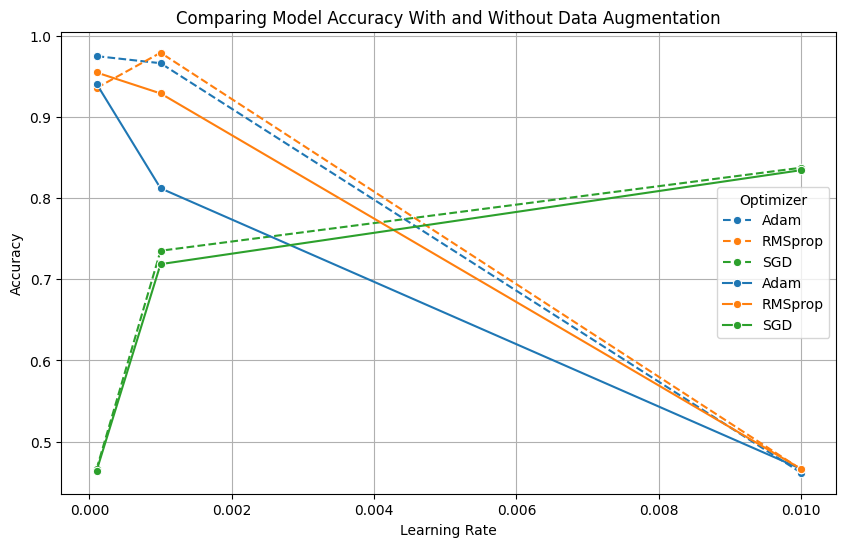

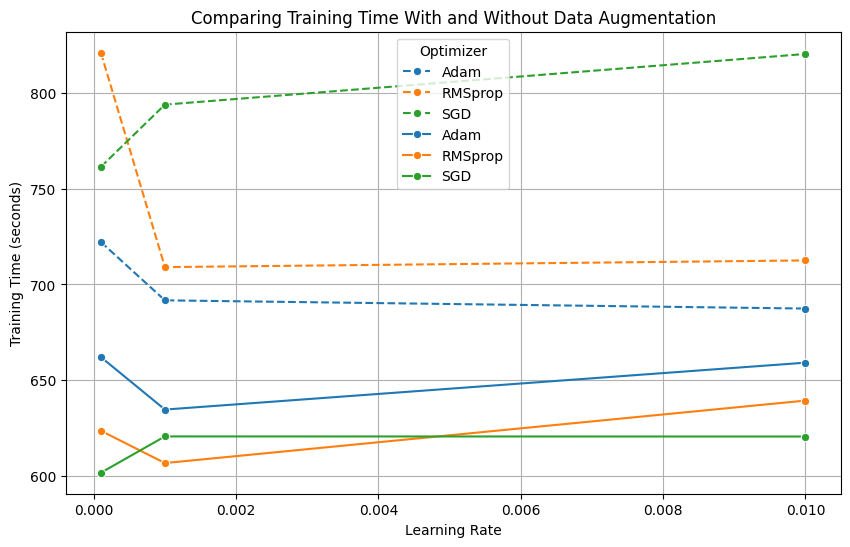

In [ ]:
# Training results without data augmentation
without_augmentation = {
    "Optimizer": ["Adam", "Adam", "Adam", "RMSprop", "RMSprop", "RMSprop", "SGD", "SGD", "SGD"],
    "Learning Rate": [0.01, 0.001, 0.0001, 0.01, 0.001, 0.0001, 0.01, 0.001, 0.0001],
    "Accuracy": [0.4617, 0.9659, 0.9746, 0.4659, 0.9788, 0.9354, 0.8372, 0.7350, 0.4659],
    "Training Time": [687.42, 691.71, 722.16, 712.55, 709.06, 820.98, 820.33, 793.89, 761.41]
}

# Training results with data augmentation
with_augmentation = {
    "Optimizer": ["Adam", "Adam", "Adam", "RMSprop", "RMSprop", "RMSprop", "SGD", "SGD", "SGD"],
    "Learning Rate": [0.01, 0.001, 0.0001, 0.01, 0.001, 0.0001, 0.01, 0.001, 0.0001],
    "Accuracy": [0.4664, 0.8119, 0.9406, 0.4664, 0.9287, 0.9545, 0.8342, 0.7185, 0.4638],
    "Training Time": [659.17, 634.69, 662.09, 639.38, 606.76, 623.63, 620.62, 620.67, 601.72]
}

# Convert to DataFrames for easy plotting
df_without = pd.DataFrame(without_augmentation)
df_with = pd.DataFrame(with_augmentation)

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_without["Learning Rate"], y=df_without["Accuracy"], hue=df_without["Optimizer"], marker="o", linestyle="--", legend='brief')  # Set legend to brief to avoid conflict
sns.lineplot(x=df_with["Learning Rate"], y=df_with["Accuracy"], hue=df_with["Optimizer"], marker="o", linestyle="-", legend='brief') # Set legend to brief to avoid conflict
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Comparing Model Accuracy With and Without Data Augmentation")
plt.legend(title="Optimizer")
plt.grid()
plt.show()

# Plot Training Time Comparison
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_without["Learning Rate"], y=df_without["Training Time"], hue=df_without["Optimizer"], marker="o", linestyle="--", legend='brief') # Set legend to brief to avoid conflict
sns.lineplot(x=df_with["Learning Rate"], y=df_with["Training Time"], hue=df_with["Optimizer"], marker="o", linestyle="-", legend='brief') # Set legend to brief to avoid conflict
plt.xlabel("Learning Rate")
plt.ylabel("Training Time (seconds)")
plt.title("Comparing Training Time With and Without Data Augmentation")
plt.legend(title="Optimizer")
plt.grid()
plt.show()